In [0]:
from pyspark.sql.functions import count, when, col, isnan, mean, mode, log, regexp_replace
from pyspark.sql import SparkSession

import urllib

# Configure access to S3 using AWS credentials

In [0]:
file_type = "csv"
first_row_is_header = "true"
delimiter = ","

aws_keys_df = spark.read.format(file_type)\
    .option("header", first_row_is_header)\
    .option("sep", delimiter)\
    .load("dbfs:/FileStore/tables/amazondataproject_accessKeys.csv")

In [0]:
# Get the AWS access key and secret key from the spark dataframe
ACCESS_KEY = aws_keys_df.select('Access key ID').take(1)[0]['Access key ID']
SECRET_KEY = aws_keys_df.select('Secret access key').take(1)[0]['Secret access key']
# Encode the secrete key
ENCODED_SECRET_KEY = urllib.parse.quote(string=SECRET_KEY, safe="")

In [0]:
AWS_S3_BUCKET = "amazondata"
# Mount name for the bucket
MOUNT_NAME = "/mnt/"+AWS_S3_BUCKET
SOURCE_URL = "s3n://{0}:{1}@{2}".format(ACCESS_KEY, ENCODED_SECRET_KEY, AWS_S3_BUCKET)
# Mount the drive
dbutils.fs.mount(SOURCE_URL, MOUNT_NAME)

# Check if the AWS S3 bucket was mounted successfully
# It will display all the file in my s3 bucket
display(dbutils.fs.ls(MOUNT_NAME+"/amazon/"))

path,name,size,modificationTime
dbfs:/mnt/amazondatavalencialeonel/amazon/Air Conditioners.csv,Air Conditioners.csv,247753,1743368682000


# Data Processing with PySpark

## Data loading

Load the "Air Conditioners.csv" file into a PySpark DataFrame.

In [0]:
# File location and type
file_location = MOUNT_NAME+"/amazon/Air Conditioners.csv"
file_type = "csv"
# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

spark = SparkSession.builder.appName("AirConditionersAnalysis").getOrCreate()

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
    .option("inferSchema", infer_schema) \
    .option("header", first_row_is_header) \
    .option("sep", delimiter) \
    .load(file_location)

display(df.head())

Row(name='Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1 Convertible, Copper, Anti-Viral + Pm 2.5 Filter, 2023 Model, White, Gls18I3...', main_category='appliances', sub_category='Air Conditioners', image='https://m.media-amazon.com/images/I/31UISB90sYL._AC_UL320_.jpg', link='https://www.amazon.in/Lloyd-Inverter-Convertible-Anti-Viral-GLS18I3FWAMC/dp/B0BRKXTSBT/ref=sr_1_4?qid=1679134237&s=kitchen&sr=1-4', ratings='4.2', no_of_ratings='2,255', discount_price='₹32,999', actual_price='₹58,990')

In [0]:
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- sub_category: string (nullable = true)
 |-- image: string (nullable = true)
 |-- link: string (nullable = true)
 |-- ratings: string (nullable = true)
 |-- no_of_ratings: string (nullable = true)
 |-- discount_price: string (nullable = true)
 |-- actual_price: string (nullable = true)



## Data exploration

Explore the loaded dataset to understand its structure, identify missing values, data types, and summary statistics. Determine the shape of the data and the distribution of key variables.

In [0]:
# 1. Determine the shape of the DataFrame
print("Shape of DataFrame: Rows =", df.count(), ", Columns =", len(df.columns))

# 2. Handle non-numerical values in 'discount_price' and 'actual_price'
df = df.withColumn("discount_price", regexp_replace(col("discount_price"), "[₹,]", ""))
df = df.withColumn("actual_price", regexp_replace(col("actual_price"), "[₹,]", ""))
df = df.withColumn("discount_price", df["discount_price"].cast("double"))
df = df.withColumn("actual_price", df["actual_price"].cast("double"))
df = df.withColumn("ratings", df["ratings"].cast("int"))

# 3.. Identify columns with missing values and calculate the percentage of missing values
for col_name in df.columns:
    missing_count = df.filter(
        (col(col_name).isNull()) | (isnan(col(col_name))) | (col(col_name) == "")
    ).count()
    if missing_count > 0:
        print(f"Column '{col_name}' has {missing_count} missing values ({(missing_count / df.count()) * 100:.2f}%)")

# 4.. Analyze the distribution of key categorical columns
for col_name in ["main_category", "sub_category"]:
    df.groupBy(col_name).agg(count("*").alias("count")).show()

# 5. Explore the distribution of numerical columns
print("Distribution of Ratings:")
df.describe('ratings').show()
print("Distribution of Discount Price:")
df.describe('discount_price').show()
print("Distribution of Actual Price:")
df.describe('actual_price').show()

Shape of DataFrame: Rows = 720 , Columns = 9
Column 'ratings' has 297 missing values (41.25%)
Column 'no_of_ratings' has 287 missing values (39.86%)
Column 'discount_price' has 263 missing values (36.53%)
Column 'actual_price' has 220 missing values (30.56%)
+-------------+-----+
|main_category|count|
+-------------+-----+
|   appliances|  720|
+-------------+-----+

+----------------+-----+
|    sub_category|count|
+----------------+-----+
|Air Conditioners|  720|
+----------------+-----+

Distribution of Ratings:
+-------+-----------------+
|summary|          ratings|
+-------+-----------------+
|  count|              423|
|   mean|3.491725768321513|
| stddev|0.891934688528158|
|    min|                1|
|    max|                5|
+-------+-----------------+

Distribution of Discount Price:
+-------+------------------+
|summary|    discount_price|
+-------+------------------+
|  count|               457|
|   mean| 40756.00656455142|
| stddev|14961.100450086831|
|    min|           

## Data cleaning

Handle missing values and inconsistencies in the dataset.

In [0]:
# Impute missing values
mean_ratings = df.select(mean(col("ratings"))).collect()[0][0]
mode_no_of_ratings = df.select(mode(col("no_of_ratings"))).collect()[0][0]
mean_discount_price = df.select(mean(col("discount_price"))).collect()[0][0]
mean_actual_price = df.select(mean(col("actual_price"))).collect()[0][0]

df = df.fillna(mean_ratings, subset=["ratings"])
df = df.fillna(mode_no_of_ratings, subset=["no_of_ratings"])
df = df.fillna(mean_discount_price, subset=["discount_price"])
df = df.fillna(mean_actual_price, subset=["actual_price"])

df = df.dropDuplicates()

# Correct data types
df = df.withColumn("no_of_ratings", regexp_replace(col("no_of_ratings"), "[,]", ""))
df = df.withColumn("no_of_ratings", col("no_of_ratings").cast("int"))

display(df.head(2))

name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price
"Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1 Convertible, Copper, Anti-Viral + Pm 2.5 Filter, 2023 Model, White, Gls18I3...",appliances,Air Conditioners,https://m.media-amazon.com/images/I/31UISB90sYL._AC_UL320_.jpg,https://www.amazon.in/Lloyd-Inverter-Convertible-Anti-Viral-GLS18I3FWAMC/dp/B0BRKXTSBT/ref=sr_1_4?qid=1679134237&s=kitchen&sr=1-4,4,2255,32999.0,58990.0
"LG 1.5 Ton 5 Star AI DUAL Inverter Split AC (Copper, Super Convertible 6-in-1 Cooling, HD Filter with Anti-Virus Protectio...",appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctDL._AC_UL320_.jpg,https://www.amazon.in/LG-Convertible-Anti-Virus-Protection-RS-Q19YNZE/dp/B0BQ3MXML8/ref=sr_1_5?qid=1679134237&s=kitchen&sr=1-5,4,2948,46490.0,75990.0


## Data wrangling

Transform the data to prepare it for EDA and potential modeling.

In [0]:
# 1. Create the price_difference column
df = df.withColumn(
    "price_difference",
    when(col("actual_price") >= col("discount_price"), col("actual_price") - col("discount_price")).otherwise(0)
)

# 2. Explore and transform the no_of_ratings column
# Check for nulls or non-positive values
df = df.withColumn(
    "no_of_ratings_transformed",
    when(col("no_of_ratings") <=0, 1).otherwise(log(col("no_of_ratings") + 1))
)

# 3. (Optional) Create a price-to-rating ratio column
df = df.withColumn("price_to_rating_ratio", col("discount_price") / col("ratings"))

display(df.head(2))

name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price,price_difference,no_of_ratings_transformed,price_to_rating_ratio
"Carrier 2 Ton 3 Star AI Flexicool Inverter Split AC (Copper, Convertible 4-in-1 Cooling,Dual Filtration with HD & PM 2.5 F...",appliances,Air Conditioners,https://m.media-amazon.com/images/I/41lrtqXPiWL._AC_UL320_.jpg,https://www.amazon.in/Carrier-Inverter-Split-Copper-Flexicool/dp/B0B67S3TXP/ref=sr_1_55?qid=1679134240&s=kitchen&sr=1-55,4,66,48990.0,80890.0,31900.0,4.204692619390966,12247.5
"Amazon Basics 1 Ton 4 Star Fixed Speed Window AC (Copper, Turbo Cool, Dust Filter, 2022 Model, White)",appliances,Air Conditioners,https://m.media-amazon.com/images/I/91BcgKPL5xL._AC_UL320_.jpg,https://www.amazon.in/AmazonBasics-1-5-Ton-Air-Conditioner/dp/B08J8V4QHD/ref=sr_1_119?qid=1679134243&s=kitchen&sr=1-119,3,14,25490.0,33990.0,8500.0,2.70805020110221,8496.666666666666


## Data preparation

Prepare the data for visualization and further analysis.  This includes selecting relevant features and potentially converting some features to a more suitable format.

In [0]:
# Select relevant columns for visualization
df_visualization = df.select(
    "ratings",
    "discount_price",
    "actual_price",
    "price_difference",
    "no_of_ratings",
    "no_of_ratings_transformed",
    "price_to_rating_ratio"
)

display(df_visualization.head(5))

ratings,discount_price,actual_price,price_difference,no_of_ratings,no_of_ratings_transformed,price_to_rating_ratio
4,48990.0,80890.0,31900.0,66,4.204692619390966,12247.5
3,25490.0,33990.0,8500.0,14,2.70805020110221,8496.666666666666
4,56750.0,74990.0,18240.0,4,1.6094379124341003,14187.5
4,42000.0,58400.0,16400.0,4,1.6094379124341003,10500.0
5,39489.0,71990.0,32501.0,1,0.6931471805599453,7897.8


## Data visualization

Visualize the distribution of key features in the dataset using histograms and box plots.  Analyze the relationships between relevant features using scatter plots.


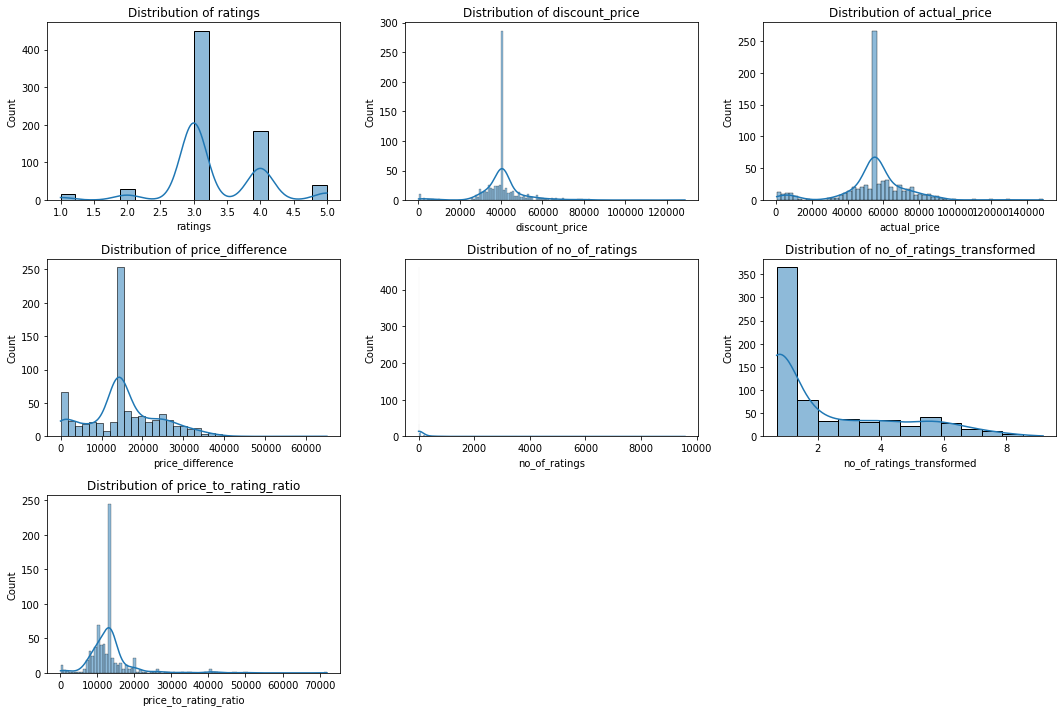

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas DataFrame for visualization
pdf = df_visualization.toPandas()

# List of numerical features
numerical_features = ['ratings', 'discount_price', 'actual_price', 'price_difference', 'no_of_ratings', 'no_of_ratings_transformed', 'price_to_rating_ratio']

# Histograms
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    sns.histplot(pdf[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

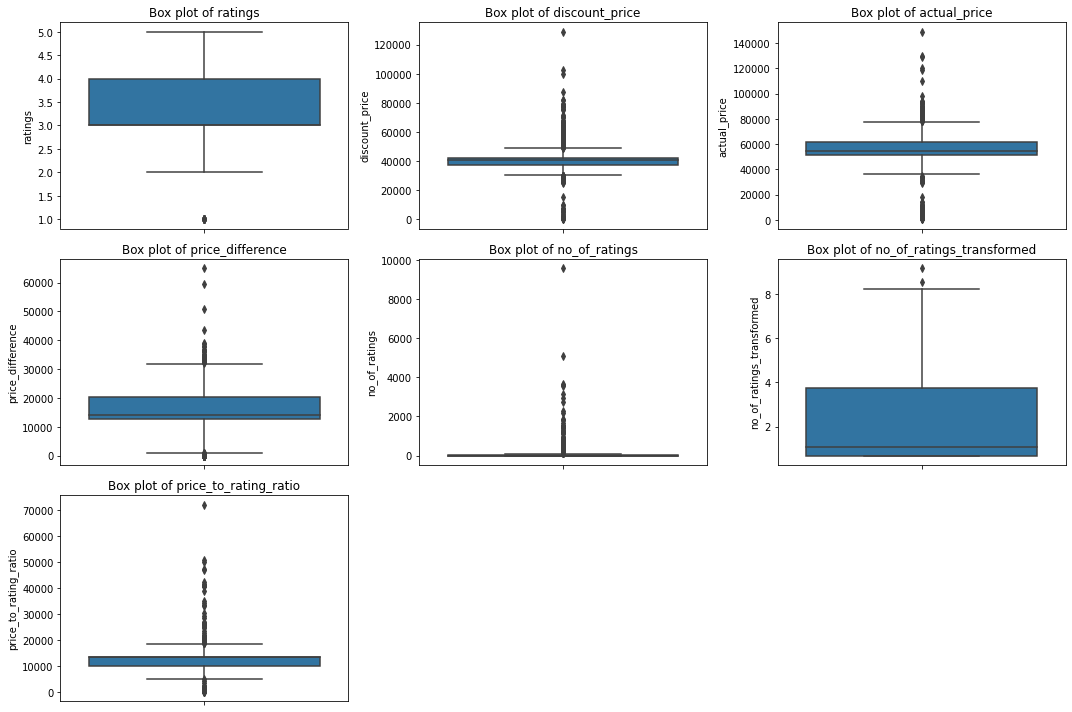

In [0]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=pdf[col])
    plt.title(f'Box plot of {col}')
plt.tight_layout()
plt.show()

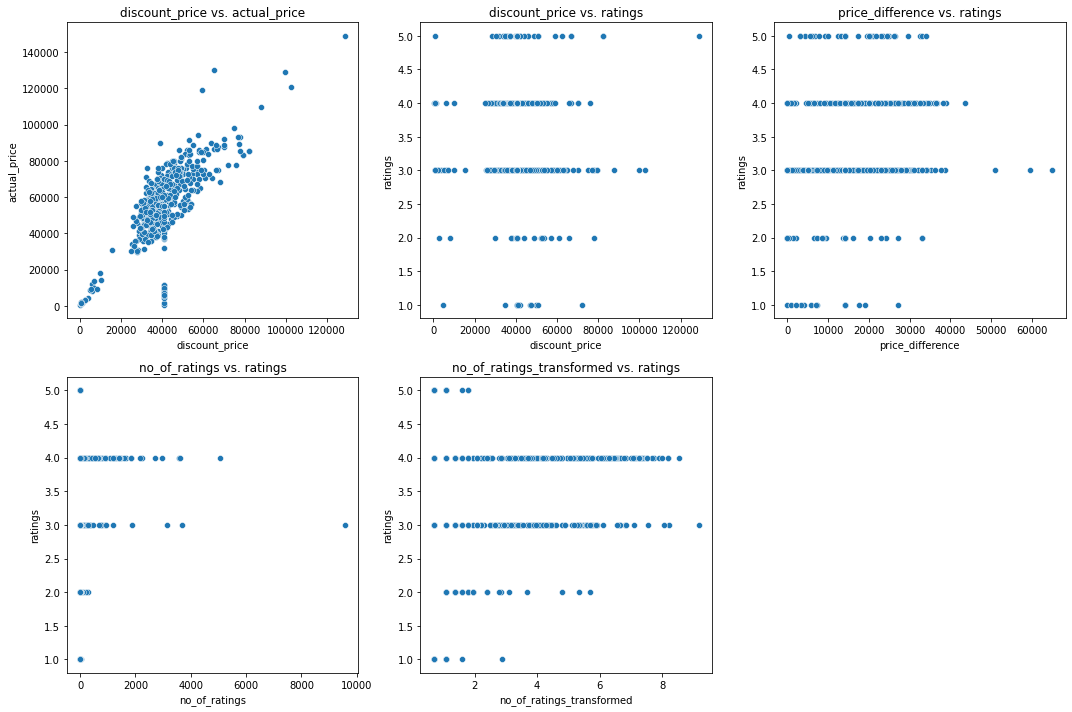

In [0]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.scatterplot(x='discount_price', y='actual_price', data=pdf)
plt.title('discount_price vs. actual_price')

plt.subplot(2, 3, 2)
sns.scatterplot(x='discount_price', y='ratings', data=pdf)
plt.title('discount_price vs. ratings')

plt.subplot(2, 3, 3)
sns.scatterplot(x='price_difference', y='ratings', data=pdf)
plt.title('price_difference vs. ratings')

plt.subplot(2, 3, 4)
sns.scatterplot(x='no_of_ratings', y='ratings', data=pdf)
plt.title('no_of_ratings vs. ratings')

plt.subplot(2, 3, 5)
sns.scatterplot(x='no_of_ratings_transformed', y='ratings', data=pdf)
plt.title('no_of_ratings_transformed vs. ratings')

plt.tight_layout()
plt.show()

## Data preparation

Convert the DataFrame `df` to the Parquet format for improved performance in subsequent analysis.

In [0]:
new_file_location = "/mnt/amazondata/amazon/updated_air_conditioners.parquet"
df.write.mode("overwrite").parquet(new_file_location)

# Loading Data into Snowflake

In [0]:
# Set up the Snowflake credentials
options = {
    "sfURL": "https://yscryt-du32091.snowflakecomputing.com",
    "sfUser": "",
    "sfPassword": "",
    "sfDatabase": "AMAZON_DATABASE",
    "sfSchema": "PUBLIC",
    "sfWarehouse": "COMPUTE_WH",
}

In [0]:
df = spark.read.format("parquet").load(
    new_file_location).write.format("snowflake").options(**options).mode("append").option("dbtable", "transformed_table").save()


In [0]:
# query the dataframe in snowflake
df = spark.read \
    .format("snowflake") \
    .options(**options) \
    .option("query", "select * from transformed_table;") \
    .load()

In [0]:
display(df)

NAME,MAIN_CATEGORY,SUB_CATEGORY,IMAGE,LINK,RATINGS,NO_OF_RATINGS,DISCOUNT_PRICE,ACTUAL_PRICE,PRICE_DIFFERENCE,NO_OF_RATINGS_TRANSFORMED,PRICE_TO_RATING_RATIO
"Carrier 2 Ton 3 Star AI Flexicool Inverter Split AC (Copper, Convertible 4-in-1 Cooling,Dual Filtration with HD & PM 2.5 F...",appliances,Air Conditioners,https://m.media-amazon.com/images/I/41lrtqXPiWL._AC_UL320_.jpg,https://www.amazon.in/Carrier-Inverter-Split-Copper-Flexicool/dp/B0B67S3TXP/ref=sr_1_55?qid=1679134240&s=kitchen&sr=1-55,4,66,48990.0,80890.0,31900.0,4.204692619390966,12247.5
"Amazon Basics 1 Ton 4 Star Fixed Speed Window AC (Copper, Turbo Cool, Dust Filter, 2022 Model, White)",appliances,Air Conditioners,https://m.media-amazon.com/images/I/91BcgKPL5xL._AC_UL320_.jpg,https://www.amazon.in/AmazonBasics-1-5-Ton-Air-Conditioner/dp/B08J8V4QHD/ref=sr_1_119?qid=1679134243&s=kitchen&sr=1-119,3,14,25490.0,33990.0,8500.0,2.70805020110221,8496.666666666666
"Carrier 2.0 Ton 5 Star Wi-Fi Inverter Split AC (Copper, 24K 5 STAR EMPERIA CXI,PM2.5 filter, 2022 Model,R32,White)",appliances,Air Conditioners,https://m.media-amazon.com/images/W/IMAGERENDERING_521856-T1/images/I/21zgJ6AsLxL._AC_UL320_.jpg,https://www.amazon.in/Carrier-Inverter-Copper-EMPERIA-CXI/dp/B09ZSTSVJ2/ref=sr_1_250?qid=1679134251&s=kitchen&sr=1-250,4,4,56750.0,74990.0,18240.0,1.6094379124341003,14187.5
"Daikin 1.5 Ton Inverter Split Ac 3 Star (Copper, FTKL/RKL-50TV16V, White)",appliances,Air Conditioners,https://m.media-amazon.com/images/I/51u1R9NZ+GL._AC_UL320_.jpg,https://www.amazon.in/Daikin-Inverter-Copper-FTKL-RKL-50TV16V/dp/B088C3QWD2/ref=sr_1_299?qid=1679134253&s=kitchen&sr=1-299,4,4,42000.0,58400.0,16400.0,1.6094379124341003,10500.0
"Voltas Split Air Conditioner SAC 185V CAZZ, White, (4503222)",appliances,Air Conditioners,https://m.media-amazon.com/images/I/61a-F8WxWOL._AC_UL320_.jpg,https://www.amazon.in/Voltas-Split-Conditioner-White-4503222/dp/B09W5K2L16/ref=sr_1_389?qid=1679134258&s=kitchen&sr=1-389,5,1,39489.0,71990.0,32501.0,0.6931471805599453,7897.8
"Amstrad 1.5 Ton 2 Star Fixed Speed AC (Copper, AM20F2CHP, White) Platinum Line 2022 Series.",appliances,Air Conditioners,https://m.media-amazon.com/images/W/IMAGERENDERING_521856-T2/images/I/51e1gly5DWL._AC_UL320_.jpg,https://www.amazon.in/Amstrad-Fixed-Copper-AM20F2CHP-Platinum/dp/B0BPXMPYB2/ref=sr_1_556?qid=1679134266&s=kitchen&sr=1-556,3,1,40756.00656455142,54815.22724,14059.220675448581,0.6931471805599453,13585.33552151714
Power Traders 1.5 Ton 5 Star Inverter Split AC,appliances,Air Conditioners,https://m.media-amazon.com/images/I/41H-5+2OzUL._AC_UL320_.jpg,https://www.amazon.in/Power-Traders-Star-Inverter-Split/dp/B0BH4MPKRR/ref=sr_1_573?qid=1679134267&s=kitchen&sr=1-573,3,1,40756.00656455142,54815.22724,14059.220675448581,0.6931471805599453,13585.33552151714
"Samsung 1.5 Ton 5 Star Convertible 5 in 1 Inverter Split AC (AR18BY5YAWK, White)",appliances,Air Conditioners,https://m.media-amazon.com/images/I/51TmvpOjB9L._AC_UL320_.jpg,https://www.amazon.in/Samsung-Convertible-Inverter-Split-AR18BY5YAWK/dp/B09VLDYKZM/ref=sr_1_628_mod_primary_new?qid=1679134269&s=kitchen&sbo=RZvfv%2F%2FHxDF%2BO5021pAnSA%3D%3D&sr=1-628,3,1,43490.0,65990.0,22500.0,0.6931471805599453,14496.666666666666
"Panasonic 1.5 Ton 3 Star Window AC (Copper, PM 2.5 Filter, 2022 Model, CW-LN182AM, White)",appliances,Air Conditioners,https://m.media-amazon.com/images/I/61E911ntaKL._AC_UL320_.jpg,https://www.amazon.in/Panasonic-Window-Copper-Filter-CW-LN182AM/dp/B09RPFQ8Z5/ref=sr_1_204?qid=1679134248&s=kitchen&sr=1-204,4,567,40756.00656455142,54815.22724,14059.220675448581,6.342121418721152,10189.001641137855
"Comfee 1.5 Ton 3 Star Non-Inverter Split AC (OAS18EE3R39F0+OF183R3AC90, White)",appliances,Air Conditioners,https://m.media-amazon.com/images/W/IMAGERENDERING_521856-T1/images/I/511IY0I9Z7L._AC_UL320_.jpg,https://www.amazon.in/Comfee-Split-Copper-OAS18EE3R39F0-OF183R3AC90/dp/B07N2WZFLZ/ref=sr_1_343?qid=1679134256&s=kitchen&sr=1-343,4,120,39000.0,49990.0,10990.0,4.795790545